In [1]:
import h5py
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import Avogadro

In [2]:
# File paths
input_file = "./endf_mf_23.txt"
output_file_photon = "photoatomic_xs.h5"
output_file_electron = "electronic_xs.h5"

In [ ]:
# parser code

In [3]:
def parse_tab1(lines, start_index):
    """Parse a single TAB1 section starting at start_index."""
    header3 = lines[start_index + 2]
    NP = int(header3[:66].split()[0])
    energy_list = []
    xs_list = []
    i = start_index + 3
    points_read = 0

    while points_read < NP:
        line = lines[i][:66]
        numbers = [float(tok) for tok in line.split()]
        for j in range(0, len(numbers), 2):
            if points_read >= NP:
                break
            energy_list.append(numbers[j])
            xs_list.append(numbers[j+1])
            points_read += 1
        i += 1
    return np.array(energy_list), np.array(xs_list), i

def parse_dictin(lines, start_index):
    """Parse the DICTIN section and return dict[(MF,MT)] = start line relative to slice."""
    dictin = {}
    i = start_index
    while int(lines[i][75:]) != 99999:
        line = lines[i]
        if not line.strip() or "*****" in line:
            break
        tokens = line[:66].split()
        if len(tokens) >= 3:
            MF = int(tokens[0])
            MT = int(tokens[1])
            length = int(tokens[2])
            dictin[(MF, MT)] = length
        i += 1
    return dictin, i+1

In [8]:
def parse_endf_photoatomic_to_hdf5(endf_file, h5_file_photon, h5_file_electron):
    """Parse ENDF MF=23 photoatomic data and store directly into HDF5."""
    particle = ['photon', 'electron']
    p = 0
    with open(endf_file, "r") as f:
        lines = f.readlines()

    with h5py.File(h5_file_photon, "w") as h5f_p:
        with h5py.File(h5_file_electron, "w") as h5f_e:
            line_num = 0
            while line_num < len(lines):
                line = lines[line_num]
                MF = int(line[70:72])
                MT = int(line[72:75])
    
                # New material header
                if MF == 1 and MT == 451:
                    # Extract Z from material description line
                    desc = lines[line_num + 4][:66].strip()
                    Z = int(desc.split('-')[0])
                    print(f"Parsing element Z={Z}")
                    if p==0 :
                        gZ = h5f_p.create_group(str(Z))
                    elif p==1:
                        gZ = h5f_e.create_group(str(Z))
                    p = (p +1)%2
                    # Search for DICTIN section
                    while "DICTIN" not in lines[line_num]:
                        line_num += 1
                    dictin, next_index = parse_dictin(lines, line_num+1)
                    begin_interaction = next_index 
                    
                    # Now parse each MT sequentially
                    i = begin_interaction + 1
                    mt_list = [mt for (mf, mt) in dictin.keys() if mf == 23]
                    gZ.create_dataset("MT", data=mt_list)
                    for (mf, mt), _ in dictin.items():
                        if mf != 23:
                            
                            continue
                        # Parse TAB1 at current line index
                        print(mt)
                        energy, xs, i_next = parse_tab1(lines, i)
                        # Store in HDF5
                        gMT = gZ.create_group(str(mt))
                        gMT.create_dataset("energy", data=energy)
                        gMT.create_dataset("xs", data=xs)
                        i = i_next+1  # move to next TAB1
    
                    line_num = i  # continue after this element
                else:
                    line_num += 1

In [10]:
parse_endf_photoatomic_to_hdf5(input_file, output_file_photon, output_file_electron)

Parsing element Z=1
501
502
504
515
516
517
522
534
Parsing element Z=1
501
522
525
526
527
528
534
Parsing element Z=2
501
502
504
515
516
517
522
534
Parsing element Z=2
501
522
525
526
527
528
534
Parsing element Z=3
501
502
504
515
516
517
522
534
535
Parsing element Z=3
501
522
525
526
527
528
534
535
Parsing element Z=4
501
502
504
515
516
517
522
534
535
Parsing element Z=4
501
522
525
526
527
528
534
535
Parsing element Z=5
501
502
504
515
516
517
522
534
535
536
537
Parsing element Z=5
501
522
525
526
527
528
534
535
536
537
Parsing element Z=6
501
502
504
515
516
517
522
534
535
536
537
Parsing element Z=6
501
522
525
526
527
528
534
535
536
537
Parsing element Z=7
501
502
504
515
516
517
522
534
535
536
537
Parsing element Z=7
501
522
525
526
527
528
534
535
536
537
Parsing element Z=8
501
502
504
515
516
517
522
534
535
536
537
Parsing element Z=8
501
522
525
526
527
528
534
535
536
537
Parsing element Z=9
501
502
504
515
516
517
522
534
535
536
537
Parsing element Z=9
501


In [74]:
# example for extraction

In [27]:
import h5py
import numpy as np

def get_total_xs(h5_file, Z=82):
    """Extract the total electron cross section for element Z from parsed HDF5."""
    with h5py.File(h5_file, "r") as h5f:
        if str(Z) not in h5f:
            raise KeyError(f"Element Z={Z} not found in {h5_file}")
        gZ = h5f[str(Z)]
        
        # MT=501 → total electron cross section
        if "501" not in gZ:
            raise KeyError(f"MT=501 not found for Z={Z}")
        
        energy = gZ["501"]["energy"][:]
        xs = gZ["501"]["xs"][:]
    return energy, xs

In [42]:
energy, xs = get_total_xs('./photoatomic_xs.h5',Z=82)

In [75]:
# Nist data

In [67]:
energy_nist = np.array([1.00000E-03, 1.50000E-03,2.00000E-03,2.48400E-03,2.48400E-03,2.53429E-03,2.58560E-03,2.58560E-03,3.00000E-03,3.06640E-03,3.06640E-03,3.30130E-03,3.55420E-03,3.55420E-03,3.69948E-03,3.85070E-03,3.85070E-03,4.00000E-03,5.00000E-03,6.00000E-03,8.00000E-03,1.00000E-02,1.30352E-02,1.30352E-02,1.50000E-02,1.52000E-02,1.52000E-02,1.55269E-02,1.58608E-02,1.58608E-02,2.00000E-02,3.00000E-02,4.00000E-02,5.00000E-02,6.00000E-02,8.00000E-02,8.80045E-02,8.80045E-02,1.00000E-01,1.50000E-01,2.00000E-01,3.00000E-01,4.00000E-01,5.00000E-01,6.00000E-01,8.00000E-01,1.00000E+00,1.25000E+00,1.50000E+00,2.00000E+00,3.00000E+00,4.00000E+00,5.00000E+00,6.00000E+00,8.00000E+00,1.00000E+01,1.50000E+01,2.00000E+01])
xs_nist = np.array([5.210E+03,2.356E+03,1.285E+03,8.006E+02,1.397E+03,1.726E+03,1.944E+03,2.458E+03,1.965E+03,1.857E+03,2.146E+03,1.796E+03,1.496E+03,1.585E+03,1.442E+03,1.311E+03,1.368E+03,1.251E+03,7.304E+02,4.672E+02,2.287E+02,1.306E+02,6.701E+01,1.621E+02,1.116E+02,1.078E+02,1.485E+02,1.416E+02,1.344E+02,1.548E+02,8.636E+01,3.032E+01,1.436E+01,8.041E+00,5.021E+00,2.419E+00,1.910E+00,7.683E+00,5.549E+00,2.014E+00,9.985E-01,4.031E-01,2.323E-01,1.614E-01,1.248E-01,8.870E-02,7.102E-02,5.876E-02,5.222E-02,4.606E-02,4.234E-02,4.197E-02,4.272E-02,4.391E-02,4.675E-02,4.972E-02,5.658E-02,6.206E-02])
len(xs_nist)

58

(0.01, 10000.0)

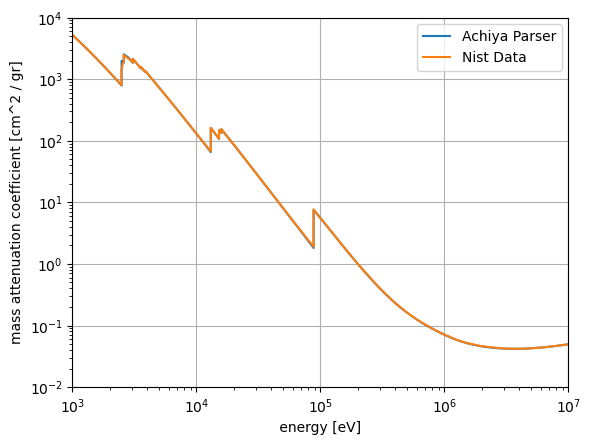

In [72]:
plt.loglog(energy,xs * (Avogadro/207.2)/1e24)
plt.loglog(energy_nist*1e6,xs_nist)
plt.grid(True)
plt.legend(['Achiya Parser', 'Nist Data'])
plt.xlabel(' energy [eV] ')
plt.ylabel('mass attenuation coefficient [cm^2 / gr]')
plt.xlim([1e3,1e7])
plt.ylim([1e-2,1e4])

In [1]:
import h5py
import xarray as xr
from typing import List, Union, Dict
import importlib.resources as pkg_resources


In [2]:
from atomxs.lib_utils import get_xs, get_MT
get_xs([10, 15], [501])

{10: {501: <xarray.DataArray 'Z10_MT501' (energy: 3840)>
  array([5.60187000e-06, 1.04596000e-05, 1.42918000e-05, ...,
         8.79842237e-01, 8.79847976e-01, 8.79880471e-01])
  Coordinates:
    * energy   (energy) float64 1.0 1.059 1.106 1.142 ... 9.63e+10 9.685e+10 1e+11},
 15: {501: <xarray.DataArray 'Z15_MT501' (energy: 5638)>
  array([5.84220000e-05, 7.51232000e-05, 8.82988000e-05, ...,
         1.86414335e+00, 1.86414397e+00, 1.86415568e+00])
  Coordinates:
    * energy   (energy) float64 1.0 1.059 1.106 ... 9.504e+10 9.529e+10 1e+11}}

In [3]:
get_MT([10,92])

{10: [501, 502, 504, 515, 516, 517, 522, 534, 535, 536, 537],
 92: [501,
  502,
  504,
  515,
  516,
  517,
  522,
  534,
  535,
  536,
  537,
  538,
  539,
  540,
  541,
  542,
  543,
  544,
  545,
  546,
  547,
  548,
  549,
  550,
  551,
  552,
  553,
  554,
  555,
  556,
  559,
  560,
  561,
  562,
  563,
  570]}

In [42]:
from scipy.constants import micro, milli, centi, minute
import numpy as np
Ci = 3.7e10
colimation_rad = 0.5 *milli 
distance = 10 * centi
activity =  100 * micro * Ci
detector_eff = 0.5
cps = activity * (np.pi*colimation_rad**2/(4*np.pi*distance**2)) * detector_eff
cps

11.562499999999996

In [44]:
cp_10_minutes = cps * 20 * minute
cp_10_minutes

13874.999999999996

In [34]:
720 *(5/60)

60.0

In [46]:
1/np.sqrt(13874.999999999996)

0.00848952719956018